In [1]:
import os
from IPython.display import Image,display
from tensorflow.keras.preprocessing.image import load_img
from PIL import ImageOps

# 数据集获取

## 设置相关信息

In [2]:
# 图像位置
input_dir = 'segdata/images/'

In [3]:
# 图像路径
input_img_path = sorted([os.path.join(input_dir, fname)
                         for fname in os.listdir(input_dir) if fname.endswith('.jpg')])

In [4]:
input_img_path

['segdata/images/Abyssinian_1.jpg',
 'segdata/images/Abyssinian_10.jpg',
 'segdata/images/Abyssinian_100.jpg',
 'segdata/images/Abyssinian_101.jpg',
 'segdata/images/Abyssinian_102.jpg',
 'segdata/images/Abyssinian_103.jpg',
 'segdata/images/Abyssinian_104.jpg',
 'segdata/images/Abyssinian_105.jpg',
 'segdata/images/Abyssinian_106.jpg',
 'segdata/images/Abyssinian_107.jpg',
 'segdata/images/Abyssinian_108.jpg',
 'segdata/images/Abyssinian_109.jpg',
 'segdata/images/Abyssinian_11.jpg',
 'segdata/images/Abyssinian_110.jpg',
 'segdata/images/Abyssinian_111.jpg',
 'segdata/images/Abyssinian_112.jpg',
 'segdata/images/Abyssinian_113.jpg',
 'segdata/images/Abyssinian_114.jpg',
 'segdata/images/Abyssinian_115.jpg',
 'segdata/images/Abyssinian_116.jpg',
 'segdata/images/Abyssinian_117.jpg',
 'segdata/images/Abyssinian_118.jpg',
 'segdata/images/Abyssinian_119.jpg',
 'segdata/images/Abyssinian_12.jpg',
 'segdata/images/Abyssinian_120.jpg',
 'segdata/images/Abyssinian_121.jpg',
 'segdata/images/

In [5]:
# 标注信息
target_dir = 'segdata/annotations/trimaps/'

In [6]:
# 目标值
target_img_path = sorted([os.path.join(target_dir, fname) for fname in os.listdir(
    target_dir) if fname.endswith('.png') and not fname.startswith('.')])

In [7]:
target_img_path

['segdata/annotations/trimaps/Abyssinian_1.png',
 'segdata/annotations/trimaps/Abyssinian_10.png',
 'segdata/annotations/trimaps/Abyssinian_100.png',
 'segdata/annotations/trimaps/Abyssinian_101.png',
 'segdata/annotations/trimaps/Abyssinian_102.png',
 'segdata/annotations/trimaps/Abyssinian_103.png',
 'segdata/annotations/trimaps/Abyssinian_104.png',
 'segdata/annotations/trimaps/Abyssinian_105.png',
 'segdata/annotations/trimaps/Abyssinian_106.png',
 'segdata/annotations/trimaps/Abyssinian_107.png',
 'segdata/annotations/trimaps/Abyssinian_108.png',
 'segdata/annotations/trimaps/Abyssinian_109.png',
 'segdata/annotations/trimaps/Abyssinian_11.png',
 'segdata/annotations/trimaps/Abyssinian_110.png',
 'segdata/annotations/trimaps/Abyssinian_111.png',
 'segdata/annotations/trimaps/Abyssinian_112.png',
 'segdata/annotations/trimaps/Abyssinian_113.png',
 'segdata/annotations/trimaps/Abyssinian_114.png',
 'segdata/annotations/trimaps/Abyssinian_115.png',
 'segdata/annotations/trimaps/Abyss

In [8]:
img_size = (160,160)
batch_size = 32
num_classes = 4

## 图像展示

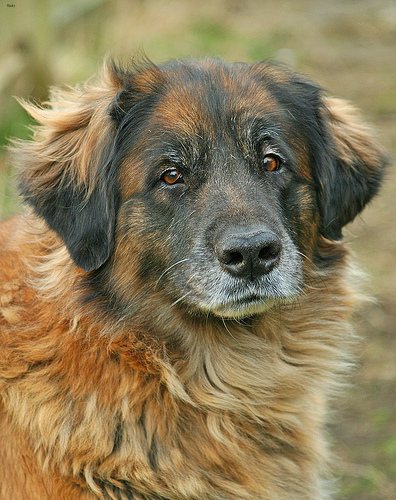

In [9]:
display(Image(input_img_path[5000]))

In [10]:
img = ImageOps.autocontrast(load_img(target_img_path[5000]))

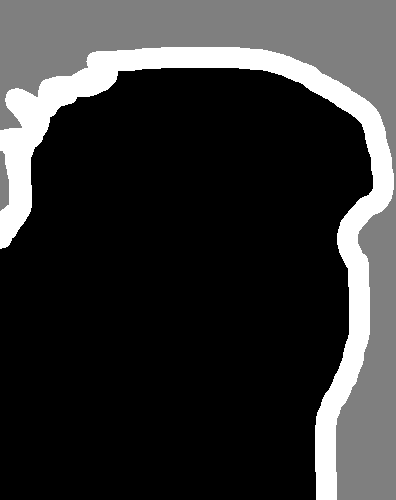

In [11]:
display(img)

## 数据集生成器

In [12]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

In [13]:
class OxfordPets(keras.utils.Sequence):
    # 初始化
    def __init__(self,batch_size,img_size,input_img_paths,target_img_paths):
        # 批次大小
        self.batch_size = batch_size
        # 图像大小
        self.img_size = img_size
        # 图像的路径
        self.input_img_paths = input_img_paths
        # 目标值路经
        self.target_img_paths = target_img_paths        

    # 迭代次数
    def __len__(self):
        return len(self.target_img_paths)//self.batch_size

    # 获取batch数据
    def __getitem__(self,idx):
        # 获取该批次对应的样本的索引
        i = idx * self.batch_size
        # 获取该批次数据
        batch_input_img_paths = self.input_img_paths[i:i+self.batch_size]
        batch_target_img_paths = self.target_img_paths[i:i+self.batch_size]
        # 构建特征值
        x = np.zeros((batch_size,)+self.img_size+(3,),dtype="float32")
        for j,path in enumerate(batch_input_img_paths):
            img = load_img(path,target_size=self.img_size)
            x[j] = img
        # 构建目标值
        y = np.zeros((batch_size,)+self.img_size+(1,),dtype='uint8')
        for j,path in enumerate(batch_target_img_paths):
            img = load_img(path,target_size=self.img_size,color_mode='grayscale')
            y[j] = np.expand_dims(img,2)
        return x,y

# 模型构建

In [14]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, Cropping2D, Concatenate
from tensorflow.keras.layers import Lambda, Activation, BatchNormalization, Dropout
from tensorflow.keras.models import Model

## 编码部分

In [15]:
def downsampling_block(input_tensor,filters):
    # 输入：input_tensor,通道数：filters
    # 卷积
    x = Conv2D(filters,kernel_size=(3,3),padding='same')(input_tensor)
    # BN 
    x = BatchNormalization()(x)
    # 激活
    x = Activation('relu')(x)
    # 卷积
    x = Conv2D(filters,kernel_size=(3,3),padding='same')(x)
    # BN 
    x = BatchNormalization()(x)
    # 激活
    x = Activation('relu')(x)
    # 返回
    return MaxPooling2D(pool_size=(2,2))(x),x

## 解码部分

In [16]:
def upsampling_block(input_tensor,skip_tensor,filters):
    # input——tensor:输入特征图，skip_tensor:编码部分的特征图，filters:通道数
    # 反卷积
    x = Conv2DTranspose(filters,kernel_size=(2,2),strides=(2,2),padding='same')(input_tensor)
    # 尺寸
    _,x_height,x_width,_ = x.shape
    _,s_height,s_width,_ = skip_tensor.shape
    # 计算差异
    h_crop = s_height-x_height
    w_crop = s_width-x_width
    # 判断是否进行裁剪
    if h_crop==0 and w_crop ==0:
        y = skip_tensor
    else:
        # 获取裁剪的大小
        cropping = ((h_crop//2,h_crop-h_crop//2),(w_crop//2,w_crop-w_crop//2))
        y = Cropping2D(cropping=cropping)(skip_tensor)
    # 特征融合
    x = Concatenate()([x,y])
    # 卷积
    x = Conv2D(filters,kernel_size=(3,3),padding='same')(x)
    # BN 
    x = BatchNormalization()(x)
    # 激活层
    x = Activation('relu')(x)
    # 卷积
    x = Conv2D(filters,kernel_size=(3,3),padding='same')(x)
    # BN 
    x = BatchNormalization()(x)
    # 激活层
    x = Activation('relu')(x)
    return x

## unet网络

In [17]:
def unet(imagesize,classes,fetures=64,depth=3):
    # 定义输入
    inputs = keras.Input(shape=(imagesize+(3,)))
    x = inputs
    # 构建编码部分
    skips = []
    for i in range(depth):
        x,x0 = downsampling_block(x,fetures)
        skips.append(x0)
        fetures *=2
    # 卷积
    x = Conv2D(filters=fetures,kernel_size=(3,3),padding='same')(x)
    # BN
    x = BatchNormalization()(x)
    # 激活
    x = Activation('relu')(x)
    # 卷积
    x = Conv2D(filters=fetures,kernel_size=(3,3),padding='same')(x)
    # BN
    x = BatchNormalization()(x)
    # 激活
    x = Activation('relu')(x)
    # 解码部分
    for i in reversed(range(depth)):
        fetures //=2
        x = upsampling_block(x,skips[i],fetures)
    # 1x1卷积
    x = Conv2D(filters= classes,kernel_size=(1,1),padding='same')(x)
    # 激活
    outputs = Activation('softmax')(x)
    return keras.Model(inputs=inputs,outputs = outputs)

In [18]:
model = unet(img_size,num_classes)

In [19]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 160, 160, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 160, 160, 64)      │           1,792 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 160, 160, 64)      │             256 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 160, 160, 64)      │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 160, 160, 64)      │          36,928 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 160, 160, 64)      │             256 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 160, 160, 64)      │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 80, 80, 64)        │               0 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 80, 80, 128)       │          73,856 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 80, 80, 128)       │             512 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 80, 80, 128)       │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 80, 80, 128)       │         147,584 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 80, 80, 128)       │             512 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 80, 80, 128)       │               0 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 40, 40, 128)       │               0 │ activation_3[0][0]         │
│ (MaxPooling2D)                │                           │               

 Total params: 7,708,804 (29.41 MB)

 Trainable params: 7,703,172 (29.39 MB)

 Non-trainable params: 5,632 (22.00 KB)

In [20]:
keras.utils.plot_model(model)

You must install pydot (`pip install pydot`) for `plot_model` to work.


# 模型训练

## 数据集划分

In [21]:
import random

In [22]:
# 验证集数量
val_samples = 1000

In [23]:
# 打乱
random.Random(1337).shuffle(input_img_path)
random.Random(1337).shuffle(target_img_path)

In [24]:
# 划分数据集
# 训练集
train_input_img_paths = input_img_path[:-val_samples]
train_target_img_paths = target_img_path[:-val_samples]
# 验证集
val_input_img_paths = input_img_path[-val_samples:]
val_target_img_paths = target_img_path[-val_samples:]

## 数据集获取

In [25]:
train_gen = OxfordPets(batch_size,img_size,train_input_img_paths,train_target_img_paths)

In [26]:
val_gen = OxfordPets(batch_size,img_size,val_input_img_paths,val_target_img_paths)

## 模型编译

In [27]:
model.compile(optimizer='rmsprop',loss="sparse_categorical_crossentropy")

## 模型训练

In [28]:
model.fit(train_gen,epochs=2,validation_data=val_gen,steps_per_epoch=1,validation_steps=1)

D:\software\Anaconda\envs\py311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - loss: 1.6650 - val_loss: 25.1976
Epoch 2/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 1.7132 - val_loss: 13.5914


# 模型预测

In [34]:
val_pred = model.predict(val_gen)

31/31 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step


In [35]:
pred = val_pred[10]

In [36]:
pred.shape

(160, 160, 4)

In [37]:
mask = np.argmax(pred,axis=-1)

In [38]:
mask

array([[2, 2, 2, ..., 2, 2, 2],
       [0, 2, 2, ..., 2, 2, 2],
       [2, 0, 2, ..., 2, 2, 2],
       ...,
       [0, 2, 2, ..., 2, 2, 2],
       [2, 0, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]], dtype=int64)